In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [20]:
# Load dataset
df = pd.read_csv("crop_yield_cleaned.csv")

# Define input features and target columns
X = df[['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Annual_Rainfall']]
y = df[['Fertilizer', 'Pesticide']]


In [21]:
cat_features = ['Crop', 'Season', 'State']
num_features = ['Crop_Year', 'Area', 'Annual_Rainfall']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', SimpleImputer(strategy='median'), num_features)
])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
model = MultiOutputRegressor(LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=7,
    random_state=42
))


In [24]:
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', model)
])


In [ ]:
pipeline.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 15751, number of used features: 93
[LightGBM] [Info] Start training from score 6526992.699460


In [8]:
y_pred = pipeline.predict(X_test)

print("Fertilizer MAE:", mean_absolute_error(y_test['Fertilizer'], y_pred[:,0]))
print("Pesticide MAE:", mean_absolute_error(y_test['Pesticide'], y_pred[:,1]))

print("Fertilizer R²:", r2_score(y_test['Fertilizer'], y_pred[:,0]))
print("Pesticide R²:", r2_score(y_test['Pesticide'], y_pred[:,1]))


Fertilizer MAE: 79954.43801569125
Pesticide MAE: 309.93191042853414
Fertilizer R²: 0.9987360221030208
Pesticide R²: 0.9957096079488235


In [9]:
import joblib
joblib.dump(pipeline, 'fertilizer_pesticide_model.pkl')


['fertilizer_pesticide_model.pkl']

In [10]:
# Load saved model
pipeline = joblib.load('fertilizer_pesticide_model.pkl')

# Predict on new unseen data
new_data = pd.DataFrame({
    'Crop': ['Rice'],
    'Crop_Year': [2025],
    'Season': ['Kharif'],
    'State': ['Karnataka'],
    'Area': [2000],
    'Annual_Rainfall': [1200]
})
pred = pipeline.predict(new_data)
print("Predicted Fertilizer:", pred[0][0])
print("Predicted Pesticide:", pred[0][1])


Predicted Fertilizer: 522262.8625055965
Predicted Pesticide: 1037.055687447394


In [11]:
# Add this cell to check
print("Data Statistics:")
print(f"Average Fertilizer: {df['Fertilizer'].mean():.2f} kg")
print(f"Average Pesticide: {df['Pesticide'].mean():.2f} kg")

print("\nPercentage Errors:")
fert_pct = (79954.44 / df['Fertilizer'].mean()) * 100
pest_pct = (309.93 / df['Pesticide'].mean()) * 100
print(f"Fertilizer Error: {fert_pct:.2f}%")
print(f"Pesticide Error: {pest_pct:.2f}%")

Data Statistics:
Average Fertilizer: 6528930.84 kg
Average Pesticide: 13013.90 kg

Percentage Errors:
Fertilizer Error: 1.22%
Pesticide Error: 2.38%


In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_fert = np.sqrt(mean_squared_error(y_test['Fertilizer'], y_pred[:,0]))
rmse_pest = np.sqrt(mean_squared_error(y_test['Pesticide'], y_pred[:,1]))

print(f"Fertilizer RMSE: {rmse_fert:.2f}")
print(f"Pesticide RMSE: {rmse_pest:.2f}")

Fertilizer RMSE: 325056.69
Pesticide RMSE: 1198.23


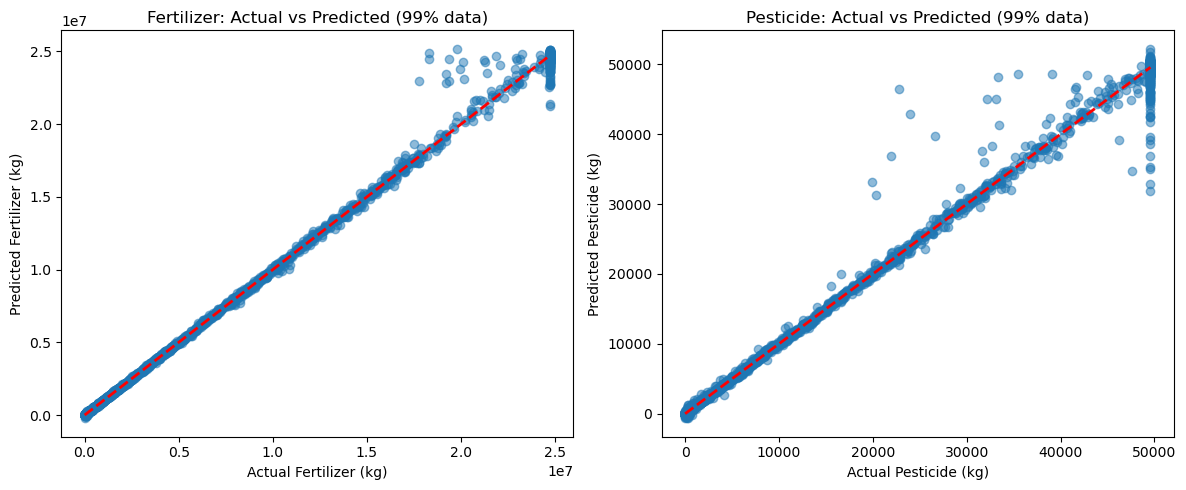

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentiles to remove extreme outliers
fert_lower = np.percentile(y_test['Fertilizer'], 1)
fert_upper = np.percentile(y_test['Fertilizer'], 99)
pest_lower = np.percentile(y_test['Pesticide'], 1)
pest_upper = np.percentile(y_test['Pesticide'], 99)

# Filter data to 1st-99th percentile
mask_fert = (y_test['Fertilizer'] >= fert_lower) & (y_test['Fertilizer'] <= fert_upper)
mask_pest = (y_test['Pesticide'] >= pest_lower) & (y_test['Pesticide'] <= pest_upper)

# Plot without extreme outliers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test['Fertilizer'][mask_fert], y_pred[:,0][mask_fert], alpha=0.5)
plt.plot([fert_lower, fert_upper], [fert_lower, fert_upper], 'r--', lw=2)
plt.xlabel('Actual Fertilizer (kg)')
plt.ylabel('Predicted Fertilizer (kg)')
plt.title('Fertilizer: Actual vs Predicted (99% data)')

plt.subplot(1, 2, 2)
plt.scatter(y_test['Pesticide'][mask_pest], y_pred[:,1][mask_pest], alpha=0.5)
plt.plot([pest_lower, pest_upper], [pest_lower, pest_upper], 'r--', lw=2)
plt.xlabel('Actual Pesticide (kg)')
plt.ylabel('Predicted Pesticide (kg)')
plt.title('Pesticide: Actual vs Predicted (99% data)')

plt.tight_layout()
plt.show()

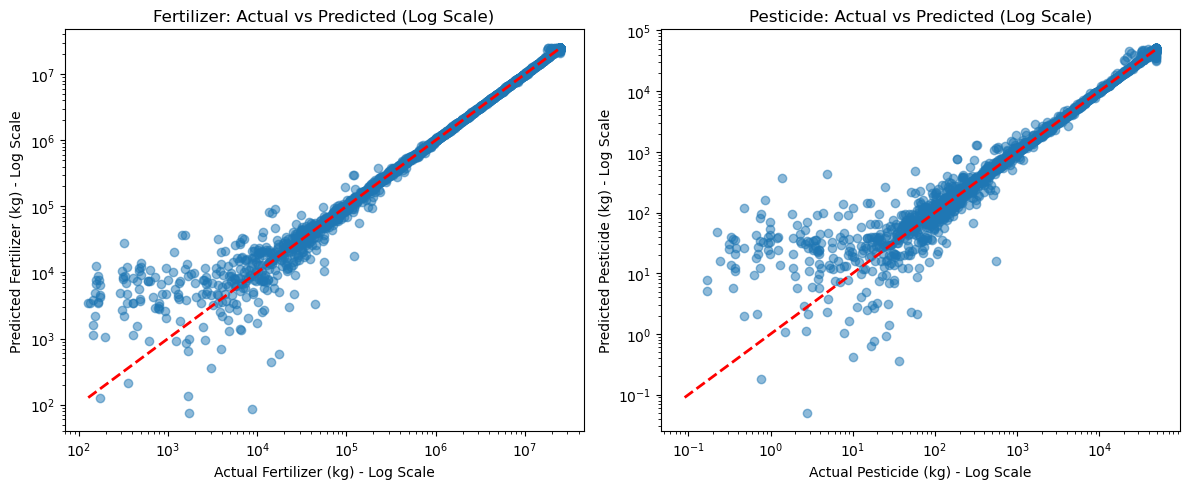

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Actual vs Predicted with LOG SCALE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test['Fertilizer'], y_pred[:,0], alpha=0.5)
plt.plot([y_test['Fertilizer'].min(), y_test['Fertilizer'].max()], 
         [y_test['Fertilizer'].min(), y_test['Fertilizer'].max()], 
         'r--', lw=2)
plt.xscale('log')  # Add log scale
plt.yscale('log')  # Add log scale
plt.xlabel('Actual Fertilizer (kg) - Log Scale')
plt.ylabel('Predicted Fertilizer (kg) - Log Scale')
plt.title('Fertilizer: Actual vs Predicted (Log Scale)')

plt.subplot(1, 2, 2)
plt.scatter(y_test['Pesticide'], y_pred[:,1], alpha=0.5)
plt.plot([y_test['Pesticide'].min(), y_test['Pesticide'].max()], 
         [y_test['Pesticide'].min(), y_test['Pesticide'].max()], 
         'r--', lw=2)
plt.xscale('log')  # Add log scale
plt.yscale('log')  # Add log scale
plt.xlabel('Actual Pesticide (kg) - Log Scale')
plt.ylabel('Predicted Pesticide (kg) - Log Scale')
plt.title('Pesticide: Actual vs Predicted (Log Scale)')

plt.tight_layout()
plt.show()

Data Distribution Analysis:

Fertilizer Statistics:
count    3.938000e+03
mean     6.536683e+06
std      9.144175e+06
min      1.277100e+02
25%      1.997894e+05
50%      1.186295e+06
75%      1.019825e+07
max      2.472760e+07
Name: Fertilizer, dtype: float64
Min: 127.71
Max: 24727596.07
Range: 24727468.36

Pesticide Statistics:
count     3938.000000
mean     12979.079932
std      18295.584030
min          0.090000
25%        390.865000
50%       2369.185000
75%      19988.175000
max      49569.200000
Name: Pesticide, dtype: float64
Min: 0.09
Max: 49569.2
Range: 49569.11


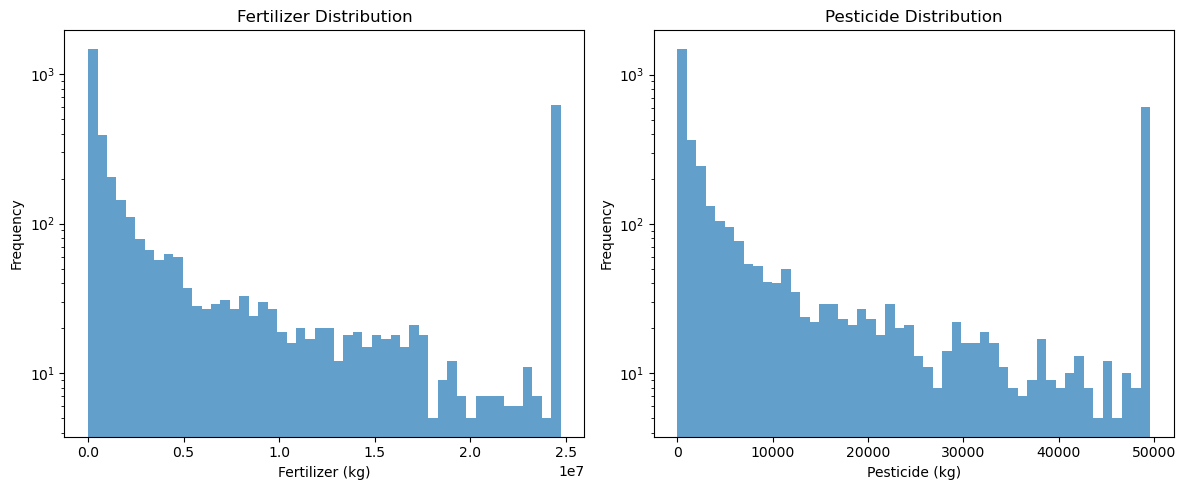

In [15]:
# Understand why plots are collapsed
print("Data Distribution Analysis:")
print("\nFertilizer Statistics:")
print(y_test['Fertilizer'].describe())
print(f"Min: {y_test['Fertilizer'].min()}")
print(f"Max: {y_test['Fertilizer'].max()}")
print(f"Range: {y_test['Fertilizer'].max() - y_test['Fertilizer'].min()}")

print("\nPesticide Statistics:")
print(y_test['Pesticide'].describe())
print(f"Min: {y_test['Pesticide'].min()}")
print(f"Max: {y_test['Pesticide'].max()}")
print(f"Range: {y_test['Pesticide'].max() - y_test['Pesticide'].min()}")

# Plot histograms to see distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test['Fertilizer'], bins=50, alpha=0.7)
plt.xlabel('Fertilizer (kg)')
plt.ylabel('Frequency')
plt.title('Fertilizer Distribution')
plt.yscale('log')  # Use log scale for y-axis

plt.subplot(1, 2, 2)
plt.hist(y_test['Pesticide'], bins=50, alpha=0.7)
plt.xlabel('Pesticide (kg)')
plt.ylabel('Frequency')
plt.title('Pesticide Distribution')
plt.yscale('log')  # Use log scale for y-axis

plt.tight_layout()
plt.show()

In [17]:
# Save the trained model to ml-service folder for integration
import joblib
import os

# Save to ml-service folder
model_path = 'ml-service/fertilizer_pesticide_model.pkl'
joblib.dump(pipeline, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📦 Model size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print("\n🎯 Model Details:")
print(f"   - Input Features: Crop, Crop_Year, Season, State, Area, Annual_Rainfall")
print(f"   - Output: [Fertilizer (kg), Pesticide (kg)]")
print(f"   - Algorithm: LightGBM (MultiOutputRegressor)")
print(f"   - Fertilizer R²: {r2_score(y_test['Fertilizer'], y_pred[:,0]):.4f}")
print(f"   - Pesticide R²: {r2_score(y_test['Pesticide'], y_pred[:,1]):.4f}")

✅ Model saved to: ml-service/fertilizer_pesticide_model.pkl
📦 Model size: 4.32 MB

🎯 Model Details:
   - Input Features: Crop, Crop_Year, Season, State, Area, Annual_Rainfall
   - Output: [Fertilizer (kg), Pesticide (kg)]
   - Algorithm: LightGBM (MultiOutputRegressor)
   - Fertilizer R²: 0.9987
   - Pesticide R²: 0.9957


In [18]:
# --- Verify and copy model to ml-service ---
import shutil
import os

# Verify the saved model is valid
print("🔍 Verifying saved model...")
test_model = joblib.load('fertilizer_pesticide_model.pkl')
print(f"✅ Model loaded successfully")
print(f"   Type: {type(test_model).__name__}")
print(f"   Has predict method: {hasattr(test_model, 'predict')}")

# Test prediction
test_data = pd.DataFrame({
    'Crop': ['Rice'],
    'Crop_Year': [2025],
    'Season': ['Kharif'],
    'State': ['Karnataka'],
    'Area': [100],
    'Annual_Rainfall': [1200]
})

test_pred = test_model.predict(test_data)
print(f"\n✅ Test prediction successful:")
print(f"   Fertilizer: {test_pred[0][0]:.2f}")
print(f"   Pesticide: {test_pred[0][1]:.2f}")

# Copy to ml-service folder
ml_service_dir = 'ml-service'
if not os.path.exists(ml_service_dir):
    os.makedirs(ml_service_dir)

src_model = 'fertilizer_pesticide_model.pkl'
dst_model = os.path.join(ml_service_dir, 'fertilizer_pesticide_model.pkl')
shutil.copy(src_model, dst_model)
print(f"\n✅ Copied {src_model} to {dst_model}")
print("🎉 Fertilizer/Pesticide model ready for ML service!")

🔍 Verifying saved model...
✅ Model loaded successfully
   Type: Pipeline
   Has predict method: True

✅ Test prediction successful:
   Fertilizer: 208973.24
   Pesticide: 346.67

✅ Copied fertilizer_pesticide_model.pkl to ml-service\fertilizer_pesticide_model.pkl
🎉 Fertilizer/Pesticide model ready for ML service!
